In [1]:
import sys
sys.path.append("..")
from IPython.display import display

In [2]:
import numpy as np
import logging
import pickle
import time
import importlib 
import copy

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)

import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors
from matplotlib.patches import Ellipse
from matplotlib import gridspec



In [139]:
from scripts import reclusterTree
from scripts import linkageList
from scripts import heatClustermap
from scripts import Tree1D
from scripts import likelihood
from scripts import beamsearchTJS
from scripts import N2Greedy
from scripts import beamSearch as bs
from scripts import beamSearchOptimal as BSO

In [140]:
"""Reload filles after changes"""
importlib.reload(reclusterTree)
importlib.reload(linkageList)
importlib.reload(heatClustermap)
importlib.reload(Tree1D)
importlib.reload(likelihood)
importlib.reload(N2Greedy)
importlib.reload(bs)
importlib.reload(BSO)

<module 'scripts.beamSearchOptimal' from '/Users/sebastianmacaluso/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamSearchOptimal.py'>

# CLUSTERING ALGORITHMS TESTED ON JETS GENERATED WITH THE TOY GENERATIVE MODEL 

Functions to run the reclustering algorithms over a list of jets

### Greedy Algorithm

In [6]:
def fill_GreedyList(input_jets, Nbest = 1,k1=0,k2=2):
    
    """ Run the greedy algorithm over a list of sets of input jets. 
        Args: input jets
        returns: clustered jets
                     jets logLH
    """

    input_dir= "data/truth/"
    
    with open(input_dir+ str(input_jets) + '.pkl', "rb") as fd: 
        truth_jets = pickle.load(fd, encoding='latin-1')[k1:k2]
    
    startTime= time.time()

    greedyJets = [ N2Greedy.recluster(
        truth_jet,
        delta_min =  truth_jet["pt_cut"] ,
        lam = float(truth_jet["Lambda"]),
        visualize = False,
    ) for truth_jet in truth_jets]

    print("TOTAL TIME = ",time.time() -startTime)
    
    greedyJetsLogLH = [sum(jet["logLH"]) for jet in greedyJets]
    
    return greedyJets, greedyJetsLogLH

### Beam Search Algorithm

In [7]:

def fill_BSList(input_jets, Nbest = 1, k1 = 0, k2 = 2):
    
    """ Run the Beam search algorithm (algorithm where when the logLH of 2 or more trees is the same, we only keep one of them) over a list  of sets of input jets. 
        Args: input jets
        returns: clustered jets
                     jets logLH
    """
    
    input_dir= "data/truth/"
    
    with open(input_dir+ str(input_jets) + '.pkl', "rb") as fd: 
        truth_jets = pickle.load(fd, encoding='latin-1')[k1:k2]
    
    startTime= time.time()
    BSO_jetsList =[]

    a = time.time()
    
    for i,truth_jet in enumerate(truth_jets):
        
            if i%50==0:
                print(" # of reclustered jets = ",i,"; Partial time = ",time.time() -a)
#                 print("PARTIAL TIME = ",time.time() -a)
                a = time.time()

            N = len(truth_jet["leaves"])

            BSO_jetsList.append(BSO.recluster( 
                truth_jet, 
                beamSize = min(3*N,np.asarray(N*(N-1)/2 ).astype(int)),
                delta_min =  truth_jet["pt_cut"],
                lam = float(truth_jet["Lambda"]),
                N_best = Nbest,
            )[0]
            )

    print("TOTAL TIME = ",time.time() -startTime)
    
    BSO_jetsListLogLH = [sum(jet["logLH"]) for jet in BSO_jetsList]
    
    return BSO_jetsList, BSO_jetsListLogLH

In [10]:
def fill_BSList_heap(input_jets, Nbest = 1, k1 = 0, k2 = 2):
    
    """ Run the Beam search algorithm (Straightforward implementation of beam search) over a list  of sets of input jets. 
        Args: input jets
        returns: clustered jets
                     jets logLH
    """

    input_dir= "data/truth/"
    
    with open(input_dir+ str(input_jets) + '.pkl', "rb") as fd: 
        truth_jets = pickle.load(fd, encoding='latin-1')[k1:k2]
    
    startTime= time.time()
    BSO_jetsList =[]

    a = time.time()
    
    for i,truth_jet in enumerate(truth_jets):
        
            if i%50==0:
                print(" # of reclustered jets = ",i,"; Partial time = ",time.time() -a)
#                 print("PARTIAL TIME = ",time.time() -a)
                a = time.time()

            N = len(truth_jet["leaves"])

            BSO_jetsList.append(bs.recluster( 
                truth_jet, 
                beamSize = min(3*N,np.asarray(N*(N-1)/2 ).astype(int)),
                delta_min =  truth_jet["pt_cut"],
                lam = float(truth_jet["Lambda"]),
                N_best = Nbest,
            )[0]
            )

    print("TOTAL TIME = ",time.time() -startTime)
    
    BSO_jetsListLogLH = [sum(jet["logLH"]) for jet in BSO_jetsList]
    
    return BSO_jetsList, BSO_jetsListLogLH

## COMPARISON

In [11]:
def appendTruthJets(start, end, Njets):
        """ Load truth trees and create logLH lists """
        
        dic = {}
        
        Total_jetsList =[]
        Total_jetsListLogLH = []
        avg_logLH = []
        Nconst = []
        
        for i in range(start,end):
                with open("data/truth/tree_"+str(Njets)+"_truth_"+str(i)+".pkl", "rb") as fd:
                        jetsList = pickle.load(fd, encoding='latin-1')
                    
                """Number of jet constituents"""
                Nconst.append([len(jet["leaves"]) for jet in jetsList])  
                    
                """Fill jet dictionaries with log likelihood of truth jet"""
                [likelihood.enrich_jet_logLH(truth_jet) for truth_jet in jetsList]
            
                enrichTruthLogLH = [ np.sum(truth_jet["logLH"]) for truth_jet in jetsList]
            
                Total_jetsList.append(jetsList)
                Total_jetsListLogLH.append(enrichTruthLogLH)
                avg_logLH.append(np.average(enrichTruthLogLH))

                
        """ Standard deviation for the average log LH for the N runs"""
        sigma = np.std(avg_logLH)  
        
        """ Statistical error for the mean log LH for the  total number of jets as err = sqrt(s)/ sqrt(N), where  s is the sample variance"""
        flatTotal_jetsListLogLH = np.asarray(Total_jetsListLogLH).flatten()
        statSigma = np.std(flatTotal_jetsListLogLH)/np.sqrt(len(flatTotal_jetsListLogLH))
        
        dic["jetsList"] = np.asarray(Total_jetsList)
        dic["NconstList"] = np.asarray(Nconst)
        dic["jetsListLogLH"] =  np.asarray(Total_jetsListLogLH)
        dic["flatjetsListLogLH"] = flatTotal_jetsListLogLH
        dic["avgLogLH"] = np.asarray(avg_logLH)
        dic["sigma"] = sigma
        dic["statSigma"] = statSigma
        
        return dic
                

#### Greedy

In [12]:
def runGreedy_Scan(start, end, Njets):
        """ Run greedy algorithm"""
        
        for i in range(start,end):
            jetsList, jetsListLogLH = fill_GreedyList("tree_"+str(Njets)+"_truth_"+str(i), k1 = 0, k2 = Njets)
            
            with open("data/GreedyJets/Greedy_"+str(Njets)+"Mw_"+str(i)+".pkl", "wb") as f: 
                pickle.dump((jetsList, jetsListLogLH), f) 

In [13]:
"""We ran a scan for 30 sets of 500 jets each."""

Nstart = 10
Nend = 30
N_jets = 500

runGreedyScan = False

if runGreedyScan==True:
    runGreedy_Scan(Nstart,Nend,N_jets)

In [14]:
def appendGreedyJets(start, end, Njets):
        """ Load greedy trees and logLH lists """
        
        dic = {}
        
        Total_jetsList =[]
        Total_jetsListLogLH = []
        avg_logLH = []
        for i in range(start,end):
                with open("data/GreedyJets/Greedy_"+str(Njets)+"Mw_"+str(i)+".pkl", "rb") as fd:
                    jetsList, jetsListLogLH= pickle.load(fd, encoding='latin-1')
            
                Total_jetsList.append(jetsList)
                Total_jetsListLogLH.append(jetsListLogLH)
                avg_logLH.append(np.average(jetsListLogLH))

                
        """ Standard deviation for the average log LH for the N runs"""
        sigma = np.std(avg_logLH)  
        
        """ Statistical error for the mean log LH for the  total number of jets as err = sqrt(s)/ sqrt(N), where sigma s the sample variance"""
        flatTotal_jetsListLogLH = np.asarray(Total_jetsListLogLH).flatten()
        statSigma = np.std(flatTotal_jetsListLogLH)/np.sqrt(len(flatTotal_jetsListLogLH))
        
        dic["jetsList"] = np.asarray(Total_jetsList)
        dic["jetsListLogLH"] =  np.asarray(Total_jetsListLogLH)
        dic["flatjetsListLogLH"] = flatTotal_jetsListLogLH
        dic["avgLogLH"] = np.asarray(avg_logLH)
        dic["sigma"] = sigma
        dic["statSigma"] = statSigma
        
        return dic
                

#### Beam Search

In [15]:
def runBSO_Scan(start, end, Njets):
        """ Run beam search algorithm"""
        
        for i in range(start,end):
            BSO_jetsList, BSO_jetsListLogLH = fill_BSList("tree_"+str(Njets)+"_truth_"+str(i), k1 = 0, k2 = Njets)
            
            with open("data/BeamSearchJets/BSO_"+str(Njets)+"Mw_"+str(i)+".pkl", "wb") as f: 
                pickle.dump((BSO_jetsList,BSO_jetsListLogLH), f) 

In [16]:
"""We ran a scan for 10 sets of 500 jets each. (Below as an example there is a scan for 4 sets of 2 jets each)"""

Nstart = 0
Nend = 4
N_jets = 2

runBSOScan = False

if runBSOScan==True:
    runBSO_Scan(Nstart,Nend,N_jets)

In [17]:
def appendBSO_Scan(start, end, Njets):
        """ Load beam search trees and logLH lists """
        
        dic = {}
        
        Total_jetsList =[]
        Total_jetsListLogLH = []
        avg_logLH = []
        for i in range(start,end):
                with open("data/BeamSearchJets/BSO_"+str(Njets)+"Mw_"+str(i)+".pkl", "rb") as fd:
                    jetsList, jetsListLogLH= pickle.load(fd, encoding='latin-1')
            
                Total_jetsList.append(jetsList)
                Total_jetsListLogLH.append(jetsListLogLH)
                avg_logLH.append(np.average(jetsListLogLH))

        """ Standard deviation for the average log LH for the N runs"""
        sigma = np.std(avg_logLH)  
        
        """ Statistical error for the mean log LH for the  total number of jets as err = sqrt(s)/ sqrt(N), where sigma s the sample variance"""
        flatTotal_jetsListLogLH = np.asarray(Total_jetsListLogLH).flatten()
        statSigma = np.std(flatTotal_jetsListLogLH)/np.sqrt(len(flatTotal_jetsListLogLH))
        
        dic["jetsList"] = np.asarray(Total_jetsList)
        dic["jetsListLogLH"] =  np.asarray(Total_jetsListLogLH)
        dic["flatjetsListLogLH"] = flatTotal_jetsListLogLH
        dic["avgLogLH"] = np.asarray(avg_logLH)
        dic["sigma"] = sigma
        dic["statSigma"] = statSigma
        
        return dic

## Jet Clutering Analysis

Load truth and reclustered jets 

In [18]:
Nstart = 0
Nend = 30
N_jets = 500

In [19]:
truth_dic  = appendTruthJets(Nstart,Nend,N_jets)

In [20]:
Greedy_dic = appendGreedyJets(Nstart,Nend,N_jets)

In [21]:
BSO_dic = appendBSO_Scan(Nstart,Nend,N_jets)

In [22]:
print(" Truth mean logLH =  %0.1f $\pm$ %0.1f" %(np.average(truth_dic["avgLogLH"]),  truth_dic["sigma"]))
print(" Greedy mean logLH = %0.1f $\pm$ %0.1f" %(np.average(Greedy_dic["avgLogLH"]),  Greedy_dic["sigma"]))
print(" Beam Search mean logLH = %0.1f $\pm$ %0.1f" %(np.average(BSO_dic["avgLogLH"]),  BSO_dic["sigma"]))

 Truth mean logLH =  -76.7 $\pm$ 2.1
 Greedy mean logLH = -110.9 $\pm$ 2.7
 Beam Search mean logLH = -85.6 $\pm$ 2.2


### PLOTS

In [281]:
def LogLHscatterPlot(truthDic, GreedyDic, BSODic, truth=True):
    """ Log LH scatter plot"""
    
    truthLogLH = truthDic["flatjetsListLogLH"]
    greedy_jetsLogLH = GreedyDic["flatjetsListLogLH"]
    BSO_jetsListLogLH= BSODic["flatjetsListLogLH"]
    
    Nconst1000 = truthDic["NconstList"].flatten()

    fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
    fig2.set_size_inches(7,7)
    plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
    markersize = 1
    
    x = np.linspace(min(greedy_jetsLogLH), max(truthLogLH), 1000)
    
    if truth:

        ax1.scatter(truthLogLH , greedy_jetsLogLH, color="red", marker = "X", s=markersize, label = "Greedy")
        ax1.scatter(truthLogLH , BSO_jetsListLogLH, color='green', marker="o", s=markersize, label = "Beam Search")


        ax1.plot(x, x, color="black", linestyle='--')
        ax1.set_xlabel(r"Truth Jet log likelihood", fontsize=15)
        ax1.set_ylabel(r"Clustered Jet log likelihood", fontsize=15)
    
    else:
        
        ax1.scatter(BSO_jetsListLogLH , greedy_jetsLogLH, color="red", marker = "X", s=markersize, label = "Greedy")
        ax1.plot(x, x, color="green", linestyle='--')
        
        ax1.set_xlabel(r"Beam Search jet log likelihood", fontsize=15)
        ax1.set_ylabel(r"Greedy jet log likelihood", fontsize=15)
        
    

    ax1.grid(which='both',axis='both',linestyle='--')
    plt.legend(loc='best', fontsize=15)
    plt.grid(which='both',axis='both',linestyle='--')

    plt.show()

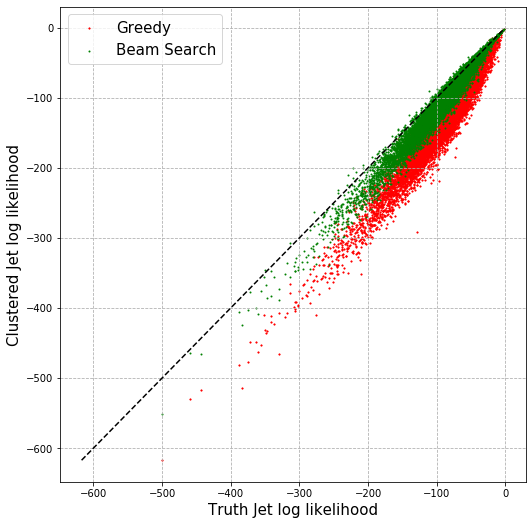

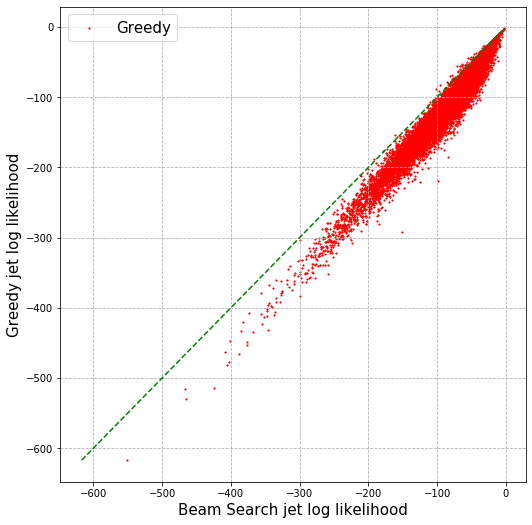

In [282]:
LogLHscatterPlot(truth_dic, Greedy_dic, BSO_dic)
LogLHscatterPlot(truth_dic, Greedy_dic, BSO_dic, truth=False)

### Delta root

In [25]:
def jetMass(DicList):
    """ Delta root (Jet Invariant Mass in the Toy Model) """
    
    jetDic = copy.copy(DicList)
    
    Mass = []
    for jet in jetDic["jetsList"].flatten():
        
        root_id = jet["root_id"]
        idL = jet["tree"][root_id][0]
        idR = jet["tree"][root_id][1]
        pL = jet["content"][idL]
        pR = jet["content"][idR]

        Mass.append(likelihood.get_delta_LR(pL, pR) )
    
    jetDic["Mass"] = Mass
    
    return jetDic

In [26]:
truth_dic = jetMass(truth_dic)

In [27]:
Greedy_dic = jetMass(Greedy_dic)

In [28]:
BSO_dic = jetMass(BSO_dic)

In [41]:
def MassHist(truthDic,
             GreedyDic,
             BSODic,
             bins = 50,
             density=None, 
             normed=None):

    """ Delta root histogram """
    
    fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
    fig2.set_size_inches(7,7)
    
    '''Same bins for all histograms'''
    bins=np.histogram(np.hstack((truthDic["Mass"],BSODic["Mass"], GreedyDic["Mass"])), bins=50)[1] #get the bin edges
    
    plt.hist(truthDic["Mass"] ,
             density = density,
             bins = bins,
             normed = normed, 
             histtype = "step",
             fill = False,
             align = 'mid',
             label = "Truth",
             color = "black")
    
    plt.hist(GreedyDic["Mass"] ,
             density = density,
             bins = bins,
             normed = normed,
             histtype = "step",
             fill = False,
             align = 'mid', 
             label = "Greedy",
             color = "r")
    
    plt.hist(BSODic["Mass"] , 
             density = density,
             bins = bins,
             normed = normed, 
             histtype = "step",  
             fill = False,
             align = 'mid',
             label = "Beam Search",
             color = "g")

    plt.xlabel(r"$\Delta_{root}$ ", fontsize=15)
    plt.ylabel(" # of Jets" , fontsize=15)
    plt.legend(loc='best', fontsize=15)
    plt.grid(which='both',axis='both',linestyle='--')

    plt.show()

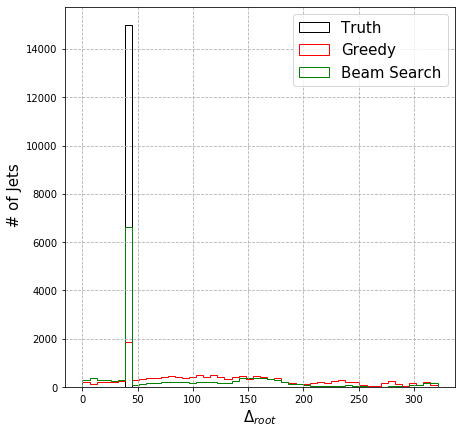

In [42]:
MassHist(truth_dic, Greedy_dic, BSO_dic)

### Momentum of the 2 subjets

In [38]:
def subjetPt(DicList):
    
    jetDic = copy.copy(DicList)
    
    pyMin = []
    pyMax=[]
    pyDiff = []
    for jet in jetDic["jetsList"].flatten():
        
        root_id = jet["root_id"]
        pP = jet["content"][root_id]
        idL = jet["tree"][root_id][0]
        idR = jet["tree"][root_id][1]
        pL = jet["content"][idL]
        pR = jet["content"][idR]

        pyMin.append(np.minimum(pL[0],pR[0]))
        pyMax.append(np.maximum(pL[0],pR[0]))
        
        pyDiff.append(- pL[0] + jet["content"][root_id][0])
        
        
    
    jetDic["SubjetPyMin"] = pyMin
    jetDic["SubjetPyMax"] = pyMax
    jetDic["SubjetPyDiff"] = pyDiff
    
    return jetDic

In [33]:
len(truth_dic["jetsList"].flatten())

15000

In [34]:
truth_dic = subjetPt(truth_dic)

In [35]:
Greedy_dic = subjetPt(Greedy_dic)

In [36]:
BSO_dic = subjetPt(BSO_dic)

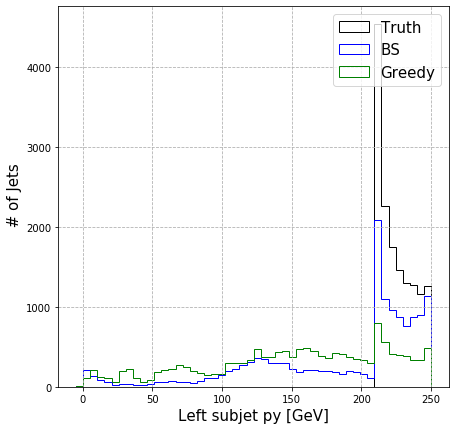

In [40]:
fig, (ax1)= plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(7,7)

bins=np.histogram(np.hstack((truth_dic["SubjetPyMin"],BSO_dic["SubjetPyMin"], Greedy_dic["SubjetPyMin"])), bins=50)[1] 

plt.hist(truth_dic["SubjetPyMin"] ,
         bins = bins,
         histtype = "step",
         fill = False, 
         align = 'mid',
         label = "Truth",
         color = "black")

plt.hist(BSO_dic["SubjetPyMin"] ,
         bins = bins,
         histtype = "step",
         fill = False, 
         align = 'mid',
         label = "BS",
         color = "blue")

plt.hist(Greedy_dic["SubjetPyMin"] ,
         bins = bins, 
         histtype = "step",
         fill = False, 
         align = 'mid',
         label = "Greedy",
         color = "green")

plt.xlabel(r"Left subjet py [GeV]", fontsize=15)
plt.ylabel(" # of Jets" , fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.grid(which='both',axis='both',linestyle='--')

plt.show()

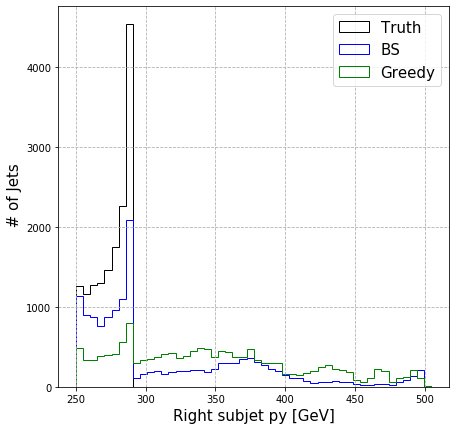

In [43]:
fig, (ax1)= plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(7,7)

bins=np.histogram(np.hstack((truth_dic["SubjetPyMax"],BSO_dic["SubjetPyMax"], Greedy_dic["SubjetPyMax"])), bins=50)[1] 

plt.hist(truth_dic["SubjetPyMax"] ,
         bins = bins,
         histtype = "step",
         fill = False, 
         align = 'mid',
         label = "Truth",
         color = "black")

plt.hist(BSO_dic["SubjetPyMax"] ,
         bins = bins,
         histtype = "step",
         fill = False, 
         align = 'mid',
         label = "BS",
         color = "blue")

plt.hist(Greedy_dic["SubjetPyMax"] ,
         bins = bins, 
         histtype = "step",
         fill = False, 
         align = 'mid',
         label = "Greedy",
         color = "green")

plt.xlabel(r"Right subjet py [GeV]", fontsize=15)
plt.ylabel(" # of Jets" , fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.grid(which='both',axis='both',linestyle='--')

plt.show()

In [53]:
def PtscatterPlot(truthDic, GreedyDic, BSODic, dicString = "SubjetPyMin" , Greedy=False, BS=False, diff = False):

    dicString = dicString 
    
    fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
    fig2.set_size_inches(7,7)
    plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
    markersize = 0.8
    
    x = np.linspace(min(truthDic[dicString]), max(truthDic[dicString]), 1000)
    
    if Greedy:

        if diff:
            ax1.scatter(truthDic["SubjetPyDiff"] , 
                        GreedyDic["SubjetPyDiff"], 
                        color="Green", 
                        marker = "X",
                        s = markersize,
                        label = "Greedy")
            
            x = np.linspace(min(truthDic["SubjetPyDiff"]), max(truthDic["SubjetPyDiff"]), 1000)
            
        else:    
            ax1.scatter(truthDic[dicString] , 
                        GreedyDic[dicString],
                        color = "Green", 
                        marker = "X",
                        s = markersize, 
                        label = "Greedy")

        ax1.plot(x, x, color="red", linestyle='--')
        ax1.set_xlabel(r"Truth Subjet Py", fontsize=15)
        ax1.set_ylabel(r"Greedy Subjet Py", fontsize=15)
        
    elif BS:
    
        if diff:
            ax1.scatter(truthDic["SubjetPyDiff"] ,
                        BSODic["SubjetPyDiff"], 
                        color = 'blue',
                        marker = "o",
                        s = markersize,
                        label = "Beam Search")
            
            x = np.linspace(min(truthDic["SubjetPyDiff"]), max(truthDic["SubjetPyDiff"]), 1000)
            
        else:
            ax1.scatter(truthDic[dicString] , 
                        BSODic[dicString],
                        color = 'blue', 
                        marker = "o", 
                        s = markersize, 
                        label = "Beam Search")
        
        ax1.plot(x, x, color="red", linestyle='--')
        ax1.set_xlabel(r"Truth Subjet Py", fontsize=15)
        ax1.set_ylabel(r"Beam Search Subjet Py", fontsize=15)
        
    else:
        
        ax1.scatter(BSODic[dicString] , 
                    GreedyDic[dicString],
                    color = "Green",
                    marker = "X",
                    s = markersize,
                    label = "Greedy")
        
        x = np.linspace(min(BSODic[dicString]), max(BSODic[dicString]), 1000)
        
        ax1.plot(x, x, color="red", linestyle='--')
        ax1.set_xlabel(r"BS Subjet Py", fontsize=15)
        ax1.set_ylabel(r"Greedy Subjet Py", fontsize=15)
        
    
    plt.legend(loc='best', fontsize=15)
    plt.grid(which='both',axis='both',linestyle='--')

    plt.show()

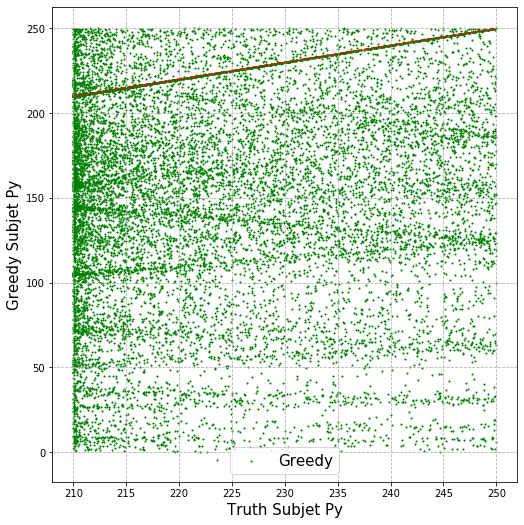

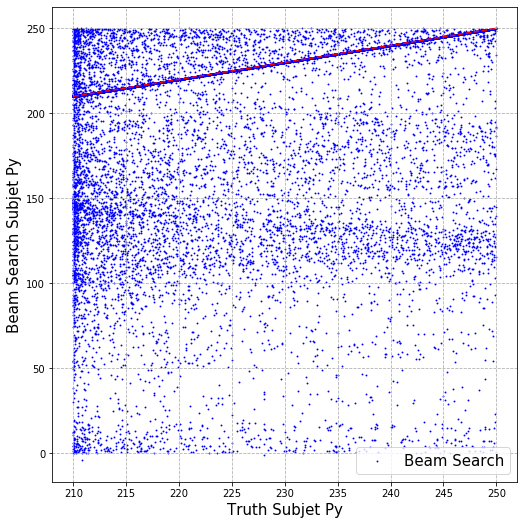

In [54]:
PtscatterPlot(truth_dic, Greedy_dic, BSO_dic,  dicString = "SubjetPyMin", Greedy=True)
# PtscatterPlot(truth_dic, Greedy_dic, BSO_dic, Greedy=True, diff=True)
PtscatterPlot(truth_dic, Greedy_dic, BSO_dic, dicString = "SubjetPyMin",  BS=True)


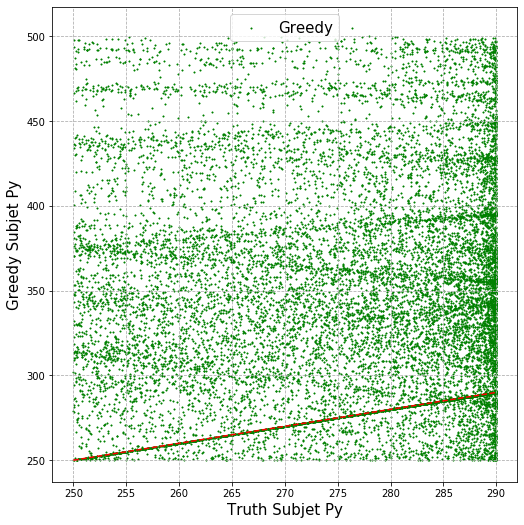

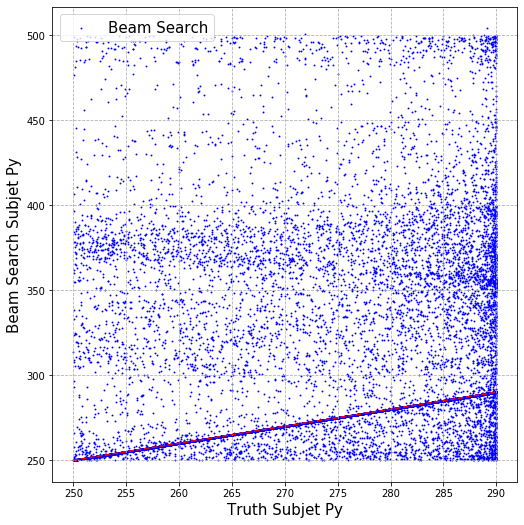

In [55]:
PtscatterPlot(truth_dic, Greedy_dic, BSO_dic,  dicString = "SubjetPyMax", Greedy=True)
# PtscatterPlot(truth_dic, Greedy_dic, BSO_dic, Greedy=True, diff=True)
PtscatterPlot(truth_dic, Greedy_dic, BSO_dic, dicString = "SubjetPyMax",  BS=True)

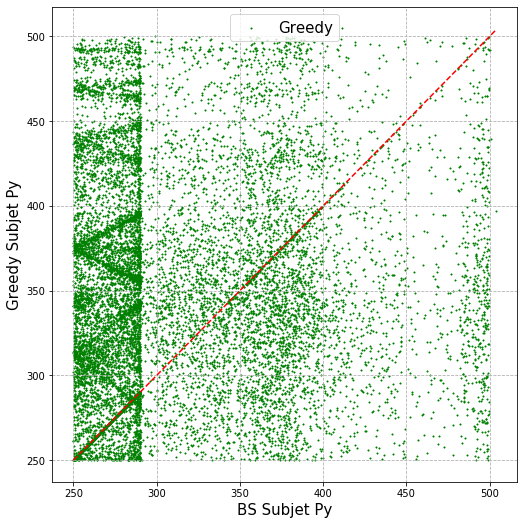

In [56]:
PtscatterPlot(truth_dic, Greedy_dic, BSO_dic, dicString = "SubjetPyMax")

### Phi angle for the (y,z) plane. Constituents angle, delta_root angle and delta_parent angle for all parents

In [69]:
def subjetPhi(DicList):
    
    """ Get dela_root phi angle and subjets angle"""
    
    jetDic = copy.copy(DicList)
    
    phiList = []
    phiDeltaList = []
    
    for jet in jetDic["jetsList"].flatten():
        
        root_id = jet["root_id"]
        idL = jet["tree"][root_id][0]
        idR = jet["tree"][root_id][1]
        pL = jet["content"][idL]
        pR = jet["content"][idR]

        delta_vec = (pR - pL) / 2

        """ arctan2 to find the right quadrant"""
        phiDelta = np.arctan2(delta_vec[0], delta_vec[1])
        phiDeltaList.append(phiDelta)

        phi1 = np.arctan2(pL[0], pL[1])
        phi2 = np.arctan2(pR[0], pR[1])

        phiList.append(phi1)
        phiList.append(phi2)


    """ Subjets angle"""
    jetDic["SubjetPhi"] = phiList
    
    """ Delta_root Phi value"""
    jetDic["SubjetPhiDelta"] = phiDeltaList
    
    return jetDic

In [58]:
truth_dic = subjetPhi(truth_dic)

In [59]:
Greedy_dic = subjetPhi(Greedy_dic)

In [60]:
BSO_dic = subjetPhi(BSO_dic)

In [65]:
def PhiHist(truthDic, 
            GreedyDic,
            BSODic,
            bins = 50,
            density = False,
            fixedJetP = False,
            Delta = False):

    
    fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
    fig2.set_size_inches(7,7)
    
    if Delta:
        
        """ Plot the angle for delta_root"""
        
        """ Set the same bin size for all histograms"""
        bins=np.histogram(np.hstack((truth_dic["SubjetPhiDelta"],BSO_dic["SubjetPhiDelta"], Greedy_dic["SubjetPhiDelta"])), bins=50)[1] #get the bin edges
        
        plt.hist(truthDic["SubjetPhiDelta"] ,
                 density = density,
                 bins = bins, 
                 histtype = "step", 
                 fill = False, 
                 align = 'mid',
                 label = "Truth", 
                 color = "black")
        
        plt.hist(GreedyDic["SubjetPhiDelta"] ,
                 density = density,
                 bins = bins, 
                 histtype = "step",
                 fill = False, 
                 align = 'mid',
                 label = "Greedy",
                 color = "red")
        
        plt.hist(BSODic["SubjetPhiDelta"] ,
                 density = density,
                 bins = bins,
                 histtype = "step",
                 fill = False,
                 align = 'mid',
                 label = "Beam Search", 
                 color = "green")

        plt.xlabel(r" $\phi$ for $\Delta_{root}$", fontsize=15)
        
    else:
        
        plt.hist(truthDic["SubjetPhi"] ,
                 density = density,
                 bins = bins, 
                 histtype = "step", 
                 fill = False, 
                 align = 'mid',
                 label = "Truth", 
                 color = "black")
        
        plt.hist(GreedyDic["SubjetPhi"] ,
                 density = density,
                 bins = bins, 
                 histtype = "step",
                 fill = False, 
                 align = 'mid',
                 label = "Greedy",
                 color = "red")
        
        plt.hist(BSODic["SubjetPhi"] ,
                 density = density,
                 bins = bins,
                 histtype = "step",
                 fill = False,
                 align = 'mid',
                 label = "Beam Search", 
                 color = "green")

        plt.xlabel(" Subjets polar angle  ", fontsize=15)

    """ If samples have all the jets with the same momentum"""
    if fixedJetP:
        
        root_id = truthDic["jetsList"][0][0]["root_id"]
        root_p = truthDic["jetsList"][0][0]["content"][root_id]
        
        jetAngle = np.arctan2(root_p[0],root_p[1])
        plt.axvline(jetAngle, color="black", linestyle='--')

        
    plt.ylabel(" # of Jets" , fontsize=15)
    plt.legend(loc='upper left', fontsize=15)
    plt.grid(which='both',axis='both',linestyle='--')

    plt.show()

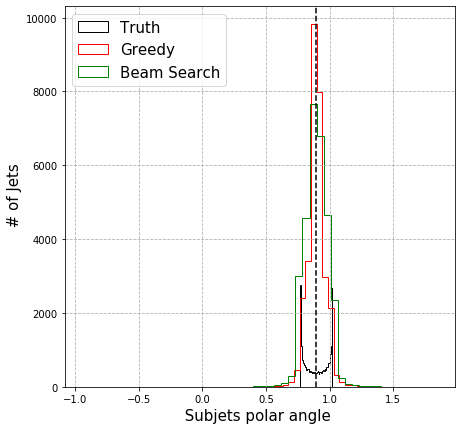

In [66]:
""" Subjets polar angle. The origin is in the beam axiz (z direction)"""
PhiHist(truth_dic, Greedy_dic, BSO_dic, fixedJetP = True)

In [68]:
def traversePhi(jet, node_id, constPhiList, PhiDeltaList):
    """
    Recursive function that traverses the tree. Gets leaves angle phi, and delta_parent phi angle for all parents in the tree.
    """

    if jet["tree"][node_id, 0] == -1:

        constPhi = np.arctan2(jet["content"][node_id][0], jet["content"][node_id][1])
        constPhiList.append(constPhi)

    else:
            
        """ Get angle for the splitting value Delta """
        idL = jet["tree"][node_id][0]
        idR = jet["tree"][node_id][1]
        pL = jet["content"][idL]
        pR = jet["content"][idR]

        delta_vec = (pR - pL) / 2

        """ arctan2 to find the right quadrant"""
        PhiDeltaList.append(np.arctan2(delta_vec[0], delta_vec[1]))
        
        
        traversePhi(
        jet,
        jet["tree"][node_id, 0],
        constPhiList,    
        PhiDeltaList,
        )

        traversePhi(
        jet,
        jet["tree"][node_id, 1],    
        constPhiList,  
        PhiDeltaList,
        )

    return constPhiList, PhiDeltaList

In [72]:
def runTraversePhi(DicList):
    
    jetDic = copy.copy(DicList)

    jetDic["jetsList"]= jetDic["jetsList"].flatten()
    
    JetsConstPhi = []
    JetsPhiDelta = []
    
    
    for jet in jetDic["jetsList"]:
        
        ConstPhi, PhiDelta = traversePhi(jet, jet["root_id"],[], [])
        jet["ConstPhi"] = ConstPhi
        jet["PhiDelta"] = PhiDelta
    
        JetsConstPhi = JetsConstPhi +ConstPhi
        JetsPhiDelta = JetsPhiDelta + PhiDelta
        

    jetDic["JetsConstPhi"] = JetsConstPhi
    jetDic["JetsPhiDelta"] = JetsPhiDelta
    
    return jetDic

In [73]:
truth_dic = runTraversePhi(truth_dic)

In [74]:
Greedy_dic = runTraversePhi(Greedy_dic)

In [75]:
BSO_dic = runTraversePhi(BSO_dic)

In [76]:
def ConstPhiHist(truthDic, bins = 50, density = False, fixedJetP = False):
    
    """ Subjets constituents angle. The origin is in the beam axiz (z direction)"""

    fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
    fig2.set_size_inches(7,7)

    plt.hist(truthDic["JetsConstPhi"] ,
             density = density,
             bins = bins, 
             histtype = "step",
             fill = False, 
             align = 'mid',
             label = "Truth",
             color = "black")

    """ If samples have all the jets with the same momentum"""
    if fixedJetP:

        root_id = truthDic["jetsList"][0]["root_id"]
        root_p = truthDic["jetsList"][0]["content"][root_id]
        jetAngle = np.arctan2(root_p[0],root_p[1])
        plt.axvline(jetAngle, color="black", linestyle='--')

    plt.xlabel(" Jets constituents polar angle  ", fontsize=15)
    plt.ylabel(" # of jets constituents" , fontsize=15)
    
    plt.legend(loc='best', fontsize=15)
    plt.grid(which='both',axis='both',linestyle='--')

    plt.show()

In [98]:
def PhiDeltaHist(truthDic, GreedyDic, BSODic, bins = 50, density = False):

    fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
    fig2.set_size_inches(7,7)

    
    """ Set the same bin size for all histograms"""
    bins=np.histogram(np.hstack((truth_dic["JetsPhiDelta"],BSO_dic["JetsPhiDelta"], Greedy_dic["JetsPhiDelta"])), bins=bins)[1] #get the bin edges
    
    plt.hist(truthDic["JetsPhiDelta"] ,
             density = density,
             bins = bins,
             histtype = "step", 
             fill = False, 
             align = 'mid',
             label = "Truth", 
             color = "black")
    
    plt.hist(GreedyDic["JetsPhiDelta"] ,
             density = density,
             bins = bins,
             histtype = "step", 
             fill = False, 
             align = 'mid',
             label = "Greedy", 
             color = "r")
        
    plt.hist(BSODic["JetsPhiDelta"] ,
             density = density,
             bins = bins,
             histtype = "step", 
             fill = False, 
             align = 'mid',
             label = "Beam Search", 
             color = "green")

    
    plt.xlabel(r"$\phi$ for all $\Delta_p$", fontsize=15)
    plt.ylabel(" # of jets inner nodes " , fontsize=15)
    
    plt.legend(loc='lower center', fontsize=15)
    plt.grid(which='both',axis='both',linestyle='--')

    plt.show()

In [99]:
def perJetPhiDeltaHist(truthDic, GreedyDic, BSODic, k=0, bins = 50, density = False):

    fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
    fig2.set_size_inches(7,7)
    
    
    """ Set the same bin size for all histograms"""
    bins=np.histogram(np.hstack((truth_dic["PhiDelta"],BSO_dic["PhiDelta"], Greedy_dic["PhiDelta"])), bins=bins)[1] #get the bin edges

    plt.hist(truthDic["jetsList"][k]["PhiDelta"] ,
             density = density,
             bins = bins,
             histtype = "step",
             fill = False, 
             align = 'mid',
             label = "Truth", 
             color = "black")
    
    plt.hist(GreedyDic["jetsList"][k]["PhiDelta"] ,
             density = density,
             bins = bins,
             histtype = "step",
             fill = False, 
             align = 'mid',
             label = "Greedy", 
             color = "r")
        
        
    plt.hist(BSODic["jetsList"][k]["PhiDelta"] ,
             density = density,
             bins = bins,
             histtype = "step",
             fill = False, 
             align = 'mid',
             label = "Beam Search", 
             color = "green")
    
    
    plt.xlabel(" Jets inner node Delta angle  ", fontsize=15)
    plt.ylabel(" # of jet inner nodes" , fontsize=15)
    
    plt.legend(loc='lower center', fontsize=15)
    plt.grid(which='both',axis='both',linestyle='--')

    plt.show()

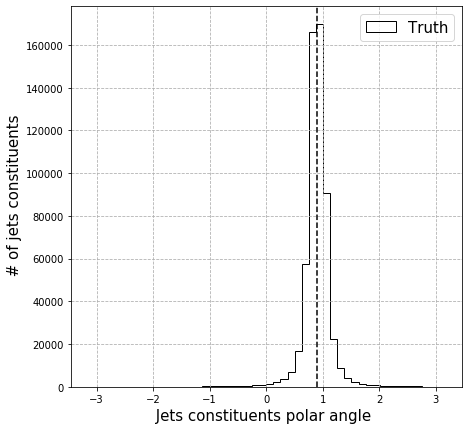

In [100]:
""" Subjets constituents angle. The origin is in the beam axiz (z direction)"""
ConstPhiHist(truth_dic, fixedJetP = True)

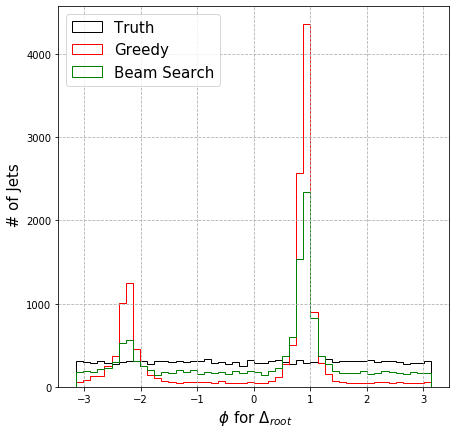

In [101]:
PhiHist(truth_dic, Greedy_dic, BSO_dic, fixedJetP = False, Delta=True)

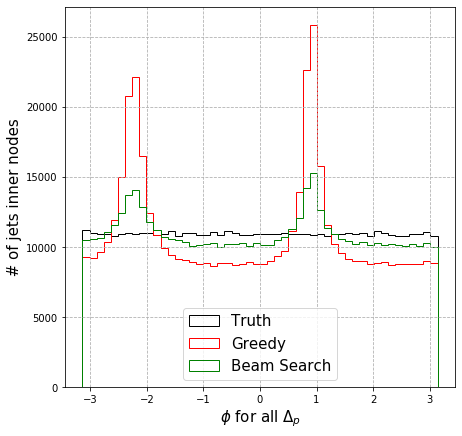

In [102]:
PhiDeltaHist(truth_dic, Greedy_dic, BSO_dic)

In [206]:
Nconst = [len(jet["leaves"]) for jet in truth_dic["jetsList"]]

In [208]:
""" Find jet location in list for a specific number of leaves"""
for i,N in enumerate(Nconst):
    if 115>N>110:
        print("Jet #",i,"N const = ",N )

Jet # 347 N const =  114
Jet # 689 N const =  114
Jet # 1147 N const =  111
Jet # 1471 N const =  111
Jet # 1869 N const =  111
Jet # 2830 N const =  113
Jet # 4918 N const =  114
Jet # 5855 N const =  113
Jet # 9385 N const =  112
Jet # 9470 N const =  111
Jet # 11923 N const =  112
Jet # 12366 N const =  113
Jet # 14528 N const =  114


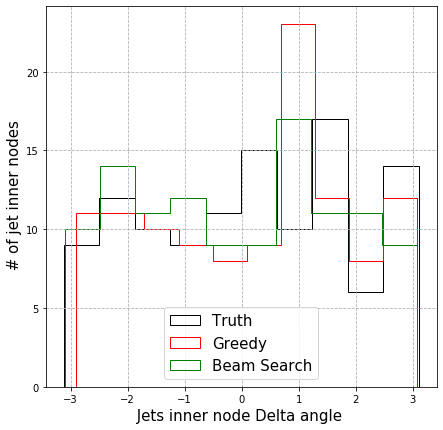

In [209]:
perJetPhiDeltaHist(truth_dic, Greedy_dic, BSO_dic, k=689, bins=10)


# Beam Search implementations: Beam Size Comparisons

In [104]:
importlib.reload(bs)
importlib.reload(BSO)

<module 'scripts.beamSearchOptimal' from '/Users/sebastianmacaluso/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamSearchOptimal.py'>

In [105]:
def truthLogLH(truth_jet,k=0):
    """ Truth jet log likelihood """
    
    likelihood.enrich_jet_logLH(truth_jet)
        
    LogLH = np.sum(truth_jet["logLH"]) 
    
    return LogLH

In [106]:
def reclustGreedyJet(truth_jet):
    """ Greedy jet reclustering """

    greedyJet = N2Greedy.recluster(
        truth_jet,
        delta_min =  truth_jet["pt_cut"] ,
        lam = float(truth_jet["Lambda"]),
        visualize = False,
    )
    
    GreedyLogLH = sum(greedyJet["logLH"])
    
    return greedyJet, GreedyLogLH

In [107]:
def beamSize_BSOList(truth_jet, beamsizeList, Nbest =1):
    """ Beam size scan for the Optimal Beam Search algorithm"""

    BSOtimeList=[]
    BSO_jets =[]

    for i in beamsizeList:  

            startTime= time.time()

            BSO_jets.append(
                BSO.recluster( 
                truth_jet, 
                beamSize = i,
                delta_min =  truth_jet["pt_cut"],
                lam = float(truth_jet["Lambda"]),
                N_best = Nbest,
            )[0]  
            )

            BSOtimeList.append(time.time() -startTime)
            
    BSO_jetsLogLH = [sum(jet["logLH"]) for jet in BSO_jets]
    
    return BSOtimeList, BSO_jets, BSO_jetsLogLH

In [108]:
def beamSize_BSList(truth_jet, beamsizeList, Nbest =1):
    """ Beam size scan for the Beam Search algorithm"""
        
    bstimeList=[]
    bs_jets =[]

    for i in beamsizeList:  

            startTime= time.time()

            bs_jets.append(
                bs.recluster( 
                truth_jet, 
                beamSize = i,
                delta_min =  truth_jet["pt_cut"],
                lam = float(truth_jet["Lambda"]),
                N_best = Nbest,
            )[-1]  
            )

            bstimeList.append(time.time() -startTime)
            
    bs_jetsLogLH = [sum(jet["logLH"]) for jet in bs_jets]
    
    return bstimeList, bs_jets, bs_jetsLogLH

### Beam size scan and plotting  functions

In [109]:
def BeamSizeLogLH(jetsName,  filename="", k=0):
    
    with open(input_dir+ str(jetsName) + '.pkl', "rb") as fd: 
        truth_jet = pickle.load(fd, encoding='latin-1')[int(k)]
    
    truthConst = N2Greedy.getConstituents(
    truth_jet,
	truth_jet["root_id"],
	[],
    )
    
    N = len(truthConst)
    
    likelihood.enrich_jet_logLH(truth_jet)
        
    truthLogLH = np.sum(truth_jet["logLH"]) 
    
    greedyJet, GreedyLogLH = reclustGreedyJet(truth_jet)

    
    beamsizeList = np.minimum(np.concatenate(([1],np.arange(0.5,5.5,0.5)*N)),np.asarray(N*(N-1)/2 *np.ones(11))).astype(int)
#     beamsizeList = np.array(([1]))

    BSOtimeList, BSO_jets, BSO_jetsLogLH = beamSize_BSOList(truth_jet, beamsizeList )
    
    bstimeList, bs_jets, bs_jetsLogLH = beamSize_BSList(truth_jet, beamsizeList )
    
    with open("data/beamScanJets/jets"+str(filename)+".pkl", "wb") as f: 
        pickle.dump((
            truth_jet,
            truthLogLH, 
            greedyJet,
            GreedyLogLH, 
            BSOtimeList,
            BSO_jets,
            BSO_jetsLogLH, 
            bstimeList, 
            bs_jets,
            bs_jetsLogLH
        ), f) 
    
    return beamsizeList

In [110]:
def plotBeamSizeLogLH(beamsizeList = None, filename=""):

        with open("data/beamScanJets/jets"+str(filename)+".pkl", "rb") as fd:  
                truth_jet,\
                truthLogLH, \
                greedyJet,\
                GreedyLogLH,\
                BSOtimeList,\
                BSO_jets,\
                BSO_jetsLogLH, \
                bstimeList, \
                bs_jets,\
                bs_jetsLogLH = pickle.load(fd, encoding='latin-1')
                

        N = BSO_jets[0]["Nconst"]
        beamsizeList = np.minimum(np.concatenate(([1],np.arange(0.5,5.5,0.5)*N)),np.asarray(N*(N-1)/2 *np.ones(11))).astype(int)
                
        truthConst = N2Greedy.getConstituents(
        truth_jet,
        truth_jet["root_id"],
        [],
        )
    
        N = len(truthConst)
        
        print("Number of leaves = ",N)

        fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
        fig2.set_size_inches(16,8)
        plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
        markersize = 100
        ax1.scatter(beamsizeList/N , BSO_jetsLogLH, color='blue', marker="s", s=markersize, label = "bs Optimal")
        ax1.scatter(beamsizeList/N , bs_jetsLogLH, color="red", marker ="o", s=markersize, label = "bs")
        ax1.scatter(1/N, GreedyLogLH, color="Green", marker = "X", s=markersize, label = "Greedy")
        ax1.scatter(1/N, truthLogLH, color="black", marker = "d", s=markersize, label = "Truth")
        ax1.grid(which='both',axis='both',linestyle='--')
        ax1.set_xlabel(r"(Beam Size)/(# leaves)", fontsize=15)
        ax1.set_ylabel("Jet log likelihood", fontsize=15)
        plt.title('Beam Size search', fontsize = 25)
        plt.legend(loc='best', fontsize=15)
        plt.grid(which='both',axis='both',linestyle='--')

### Log likelihoood vs beam size plots 

In [114]:
"""Data dir"""
input_dir= 'data/old/'
jets = "tree_100_truth"

with open(input_dir+ str(jets) + '.pkl', "rb") as fd: 
    truth_jets = pickle.load(fd, encoding='latin-1')

In [115]:
"""Number of jet constituents"""
Nconst100 = []
for jet in truth_jets:
    Nconst100.append(len(jet["leaves"]))
    
NconstAvg100 =np.average(Nconst100)
display(NconstAvg100)

36.82

In [117]:
""" Find jet location in list for a specific number of leaves"""
for i,N in enumerate(Nconst100):
    if 12>N>9:
        print("Jet #",i,"N const = ",N )

Jet # 72 N const =  11


In [118]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_72",k=72)
print("Total time = ",time.time() - startTime)

Total time =  2.057978868484497


Number of leaves =  11


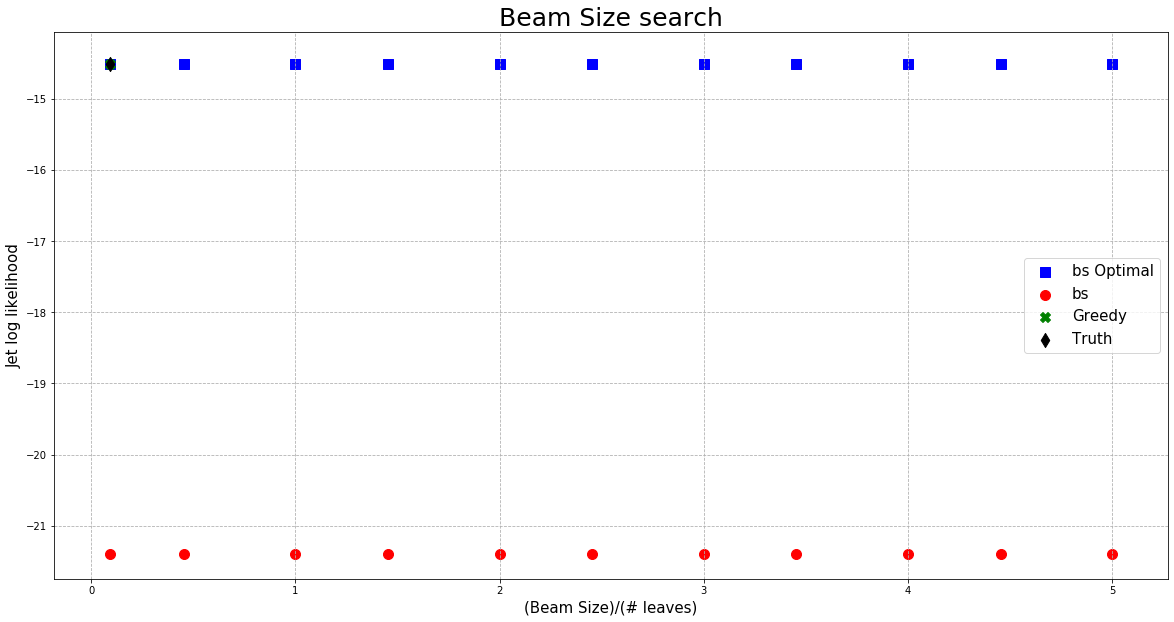

In [119]:
plotBeamSizeLogLH( filename="100_72")

In [120]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_34",k=34)
print("Total time = ",time.time() - startTime)

Total time =  20.85628390312195


Number of leaves =  22


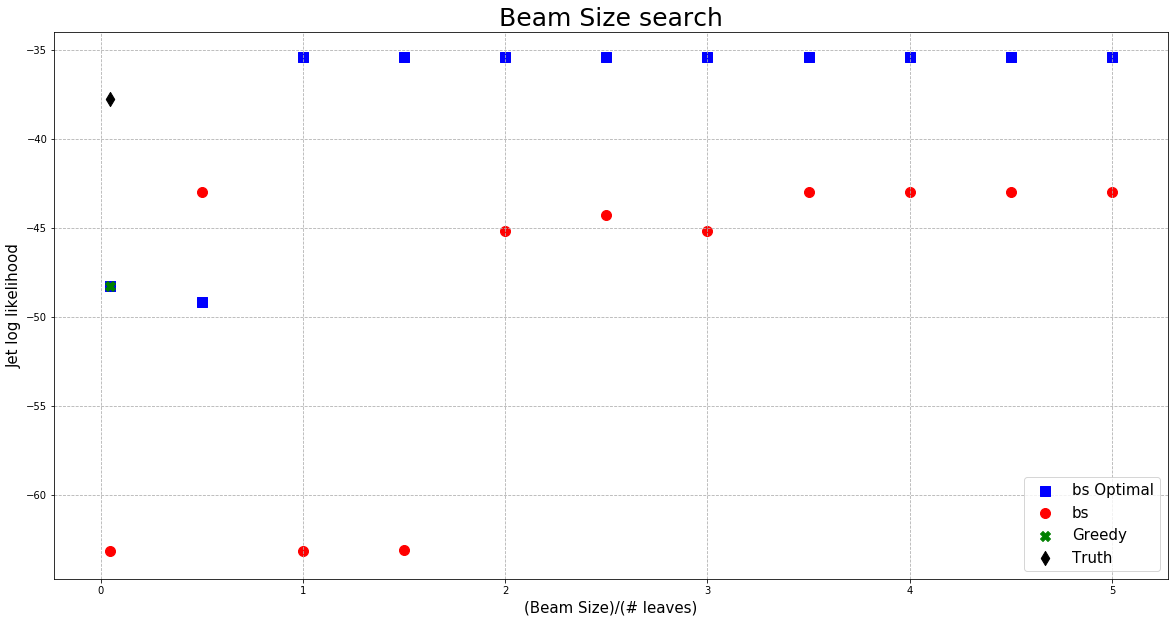

In [121]:
plotBeamSizeLogLH( filename="100_34")

In [122]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_70",k=70)
print("Total time = ",time.time() - startTime)

Total time =  346.0549330711365


Number of leaves =  50


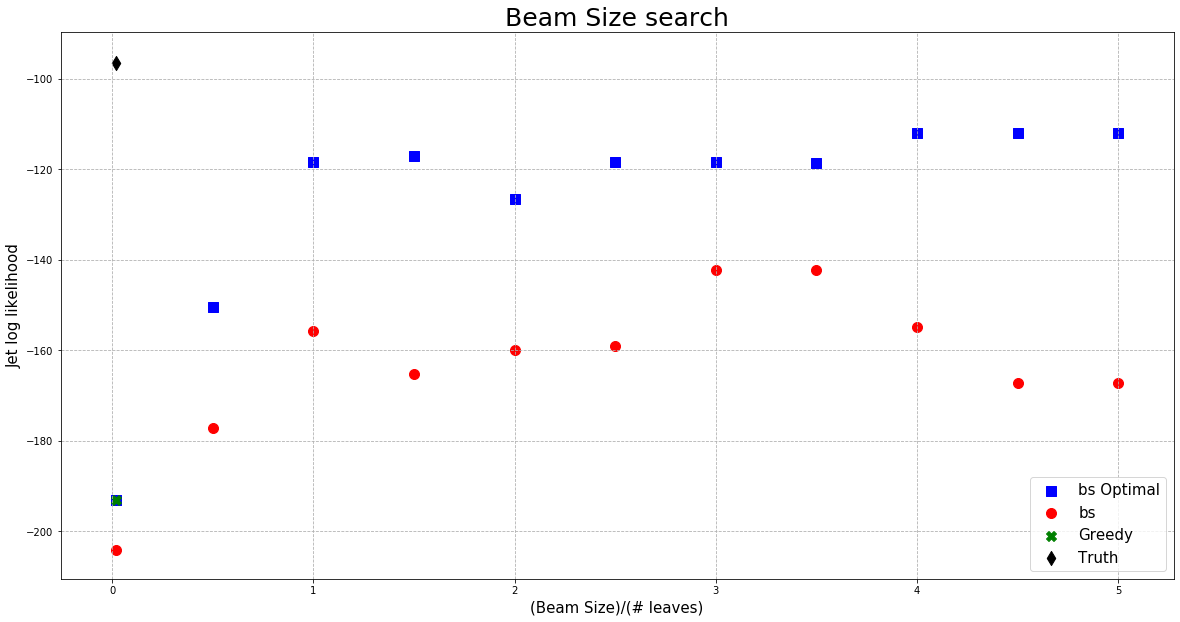

In [123]:
plotBeamSizeLogLH( filename="100_70")

In [124]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_62",k=62)
print("Total time = ",time.time() - startTime)

Total time =  4663.079787015915


Number of leaves =  98


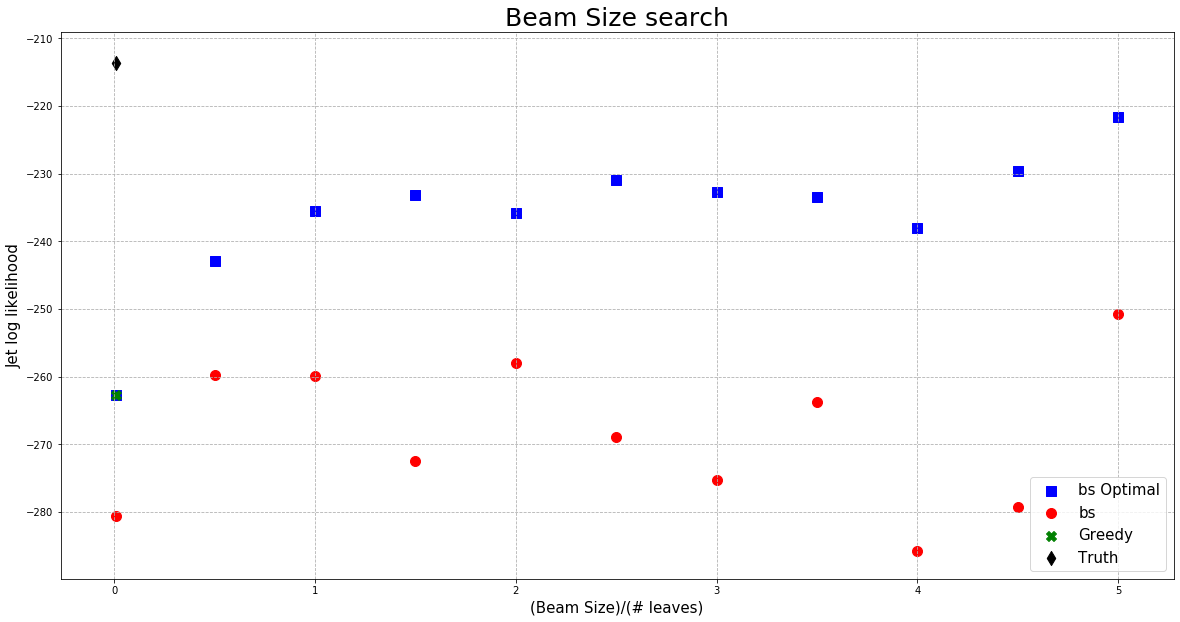

In [125]:
plotBeamSizeLogLH( filename="100_62")

## TESTS AND CODE COMPARISONS

In [151]:
def getLastSplittingProb(inputJet, node_id):
    """
    Recursive function to get a list of the tree leaves
    """
    jet = copy.deepcopy(inputJet)

    probList=[]

    left_node_id = jet["tree"][node_id,0]
    right_node_id = jet["tree"][node_id,1]
    
    if jet["tree"][left_node_id,0] == -1 and jet["tree"][right_node_id,0] == -1:
        
        probList.append(jet["logLH"][node_id - 97])
    
#     elif jet["tree"][node_id, 0] == -1:

# 		continue

    elif jet["tree"][node_id, 0] != -1:
        getLastSplittingProb(
        jet,
        jet["tree"][node_id, 0],
        )

        getLastSplittingProb(
        jet,
        jet["tree"][node_id, 1],
        )

    return probList

In [152]:
BSO_jetLastSplittingProb = getLastSplittingProb(BSO_jets[0], BSO_jets[0]["root_id"])

In [154]:
BSO_jetLastSplittingProb

[]

In [153]:
sum(BSO_jetLastSplittingProb)

0

In [32]:
# BSO_jets[0]

In [147]:
len(BSO_jets[0]["logLH"])

97

In [148]:
97+98

195

In [115]:
# BSO_jet

In [243]:
test =  bs.recluster( 
            truth_jet, 
            beamSize = 10,
            delta_min =  truth_jet["pt_cut"],
            lam = float(truth_jet["Lambda"]),
            N_best = 1,
        )[-1]  

In [244]:
test =  BSO.recluster( 
            truth_jet, 
            beamSize = 10,
            delta_min =  truth_jet["pt_cut"],
            lam = float(truth_jet["Lambda"]),
            N_best = 1,
        )[-1]  

## Duccio's beam search

In [116]:
importlib.reload(beamsearchTJS)

<module 'scripts.beamsearchTJS' from '/Users/sebastian/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamsearchTJS.py'>

In [93]:
len(truthConst)

30

In [97]:
truthConst = N2Greedy.getConstituents(
    truth_jet,	
	truth_jet["root_id"],
	[],
)

In [98]:
truthConstTriple = np.concatenate((truthConst,np.array([[0.]]*len(truthConst))),axis=1)

In [127]:
beam_Size = 20

In [128]:
a = time.time()
djet_bs_beam1 = beamsearchTJS.build_beamsearch_tree_TJS(truthConstTriple, 1, truth_jet["pt_cut"], float(truth_jet["Lambda"]))
b = time.time()
display(b-a)

0.1830611228942871

In [129]:
a = time.time()
djet_bs = beamsearchTJS.build_beamsearch_tree_TJS(truthConstTriple, beam_Size, truth_jet["pt_cut"], float(truth_jet["Lambda"]))
b = time.time()
display(b-a)

34.568865060806274

In [130]:
a = time.time()
beamSearch_jets = bs.recluster( 
    truth_jet, 
    beamSize = beam_Size,
    delta_min =  truth_jet["pt_cut"],
    lam = float(truth_jet["Lambda"]),
    N_best = 1,
)
b = time.time()
display(b-a)

10.727005958557129

In [131]:
np.sum(djet_bs["logLH"])

-74.47946266489937

In [132]:
np.sum(beamSearch_jets[-1]["logLH"])

-74.47946197240074

In [133]:
34.57/10.72

3.2248134328358207

In [126]:
8.48/2.48

3.4193548387096775